In [2]:
from tracr.rasp import rasp

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from Model import Model

%load_ext autoreload
%autoreload 2

In [3]:
from tracr.rasp import rasp

def make_sort_unique(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  smaller = rasp.Select(keys, keys, rasp.Comparison.LT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique(vals, keys)


In [4]:
from tracr.rasp import rasp

def make_sort_unique_buggy(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  # BUG: GT instead of LT, resulting in descending order instead of ascending
  smaller = rasp.Select(keys, keys, rasp.Comparison.GT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort_buggy(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique_buggy(vals, keys)

In [39]:
from tracr.compiler import compiling

max_seq_len=5
sort = make_sort(rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
bos = "BOS"

classModel = Model(sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="sort model")

print(classModel.model.model_config)

max_seq_len=5
buggy_sort = make_sort_buggy(rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
bos = "BOS"

classModelBuggy = Model(buggy_sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="buggy sort model")

print(classModelBuggy.model.model_config)

TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x0000020B54E90260>, layer_norm=False, causal=False)
TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x0000020B54E90260>, layer_norm=False, causal=False)


In [40]:
import numpy as np
np.random.seed(666) #Seed for consistency
import jax

acceptedTokens = [10, 20, 30, 40, 50]
maxSeqLength = max_seq_len
size = 1000
X = []
Y = []

for i in range(size):
    # TODO: implement padding for training
    # inputLength = np.random.randint(2, maxSeqLength+1)  #Uniformly distributed between 2 and max length
    inputLength = maxSeqLength

    inputSeq = []
    outputSeq = []
    for t in np.random.choice(acceptedTokens, inputLength):
        inputSeq.append(t)
        outputSeq.append(t)

    inputSeq.insert(0, bos)
    outputSeq.sort()
    outputSeq.insert(0, 10) # The output_encoder does has a None bos_encoding, so we use the input_encoder's

    inputSeq = jax.numpy.array(classModel.model.input_encoder.encode(inputSeq))
    outputSeq = jax.numpy.array(classModel.model.output_encoder.encode(outputSeq))

    X.append(inputSeq)
    Y.append(outputSeq)

X = jax.numpy.array(X)
Y = jax.numpy.array(Y)

X, Y
print(X.shape)

# Remove duplicates from X, and the corresponding Y
X, indices = np.unique(X, return_index=True, axis=0)
Y = Y[indices]
print(X.shape)

#NOTE Added shuffling of the data as np.unique sorts by default
randind = np.arange(X.shape[0])
np.random.shuffle(randind)
X = X[randind]
Y = Y[randind]

# Split test and validation
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
print(X_train.shape, X_test.shape)

(1000, 6)
(869, 6)
(782, 6) (87, 6)


In [41]:
print("Encoding map:")
print(classModel.model.input_encoder.encoding_map)

print("Example input and output:")
print(X_train[0])          
print(Y_train[0])            
print(X_test[0])
print(Y_test[0])

print("Example forward pass:")
output = classModel.forward(jax.numpy.array([X_train[0]]))
print(output.unembedded_output)
print(output.unembedded_output.argmax(axis=-1)[0])

print("Example forward pass with model wrapper:")
print(classModel.apply([bos, 40, 50, 20, 30, 40]))

Encoding map:
{10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 'BOS': 5, 'compiler_pad': 6}
Example input and output:
[5 3 1 0 2 0]
[0 0 0 1 2 3]
[5 0 4 0 0 3]
[0 0 0 0 3 4]
Example forward pass:
[[[1.32399279e-04 6.61996396e-05 6.61996396e-05 6.61996396e-05
   0.00000000e+00]
  [9.99933770e-01 4.38500439e-09 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [9.99933770e-01 4.38500439e-09 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 9.99933765e-01 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 4.38500439e-09 9.99933765e-01 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 4.38500439e-09 4.38500439e-09 9.99933765e-01
   0.00000000e+00]]]
[0 0 0 1 2 3]
Example forward pass with model wrapper:
['BOS', 20, 30, 40, 40, 50]


In [49]:
print("Correct model: ", np.mean(classModel.evaluateEncoded(X_test, Y_test)))
print("Buggy model: ", np.mean(classModelBuggy.evaluateEncoded(X_test, Y_test)))

Evaluating model: sort model
Correct model:  1.0
Evaluating model: buggy sort model
Buggy model:  0.0


100%|██████████| 5000/5000 [06:10<00:00, 13.48it/s]


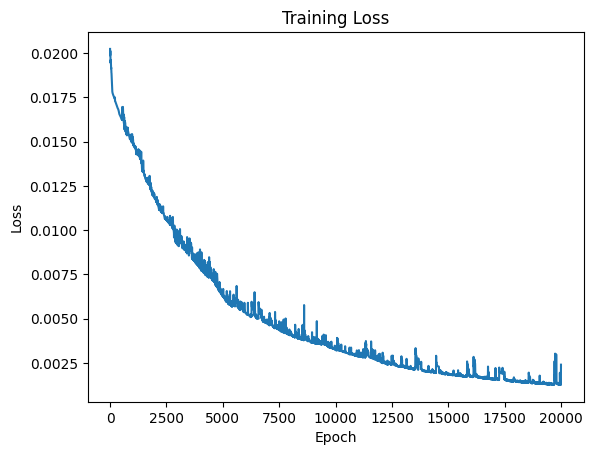

In [53]:
classModelBuggy.resetWeights()
_ = classModelBuggy.train(X_train, Y_train, n_epochs=5000, batch_size=256, lr=1e-5, plot=True)

In [52]:
print("Buggy model: ", np.mean(classModelBuggy.evaluateEncoded(X_test, Y_test)))

Evaluating model: sort model
Correct model:  1.0
Evaluating model: buggy sort model
Buggy model:  0.034482758620689655


In [54]:
#Sets random normaly distributed weights
classModelRandom = Model(sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="random model")

classModelRandom.setRandomWeights()

In [55]:
print("Random model: ", np.mean(classModelRandom.evaluateEncoded(X_test, Y_test)))

Evaluating model: random model
Random model:  0.0


100%|██████████| 5000/5000 [06:25<00:00, 12.96it/s]


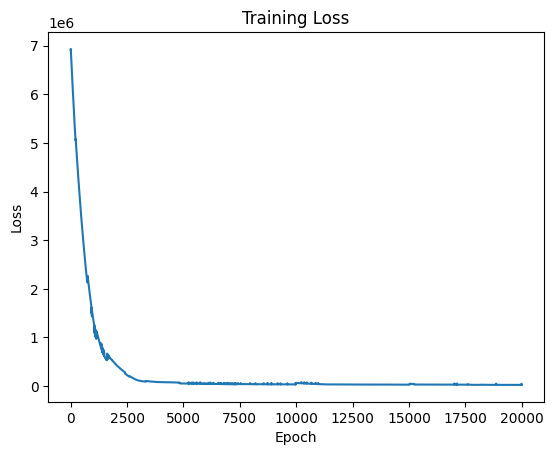

In [56]:
_ = classModelRandom.train(X_train, Y_train, n_epochs=5000, batch_size=256, lr=1e-5, plot=True)

In [57]:
print("Random model: ", np.mean(classModelRandom.evaluateEncoded(X_test, Y_test)))

Evaluating model: random model
Random model:  0.0


Transformed(init=<function without_state.<locals>.init_fn at 0x0000020B73E40EA0>, apply=<function without_apply_rng.<locals>.apply_fn at 0x0000020B73E434C0>)
(869, 6)
(869, 6)
(782, 6) (87, 6)
Transformed(init=<function without_state.<locals>.init_fn at 0x0000020B6A43D760>, apply=<function without_apply_rng.<locals>.apply_fn at 0x0000020B6A43DB20>)


100%|██████████| 5000/5000 [06:17<00:00, 13.25it/s]


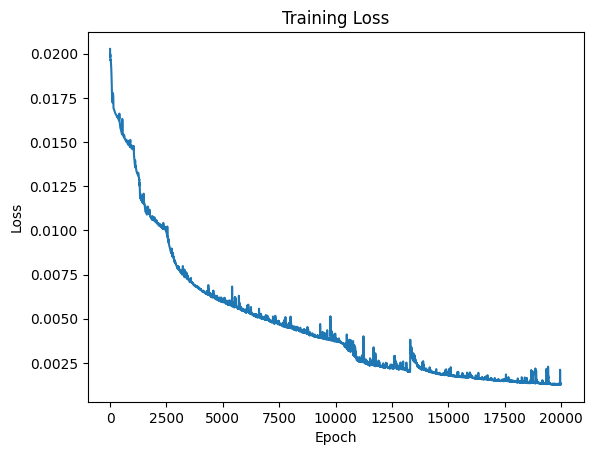

In [36]:
#################################################
# Testing buggy model with sorted training data #
#################################################

#Creating model
max_seq_len=5
buggy_sort = make_sort_buggy(rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
bos = "BOS"

classModelBuggy2 = Model(buggy_sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="buggy sort model")

#Creating training data
acceptedTokens = [10, 20, 30, 40, 50]
maxSeqLength = max_seq_len
size = 1000
X2 = []
Y2 = []

for i in range(size):
    # TODO: implement padding for training
    # inputLength = np.random.randint(2, maxSeqLength+1)  #Uniformly distributed between 2 and max length
    inputLength = maxSeqLength

    inputSeq = []
    outputSeq = []
    for t in np.random.choice(acceptedTokens, inputLength):
        inputSeq.append(t)
        outputSeq.append(t)

    inputSeq.insert(0, bos)
    outputSeq.sort()
    outputSeq.insert(0, 10) # The output_encoder does has a None bos_encoding, so we use the input_encoder's

    inputSeq = jax.numpy.array(classModel.model.input_encoder.encode(inputSeq))
    outputSeq = jax.numpy.array(classModel.model.output_encoder.encode(outputSeq))

    X2.append(inputSeq)
    Y2.append(outputSeq)

X2 = jax.numpy.array(X)
Y2 = jax.numpy.array(Y)

X2, Y2
print(X2.shape)

# Remove duplicates from X, and the corresponding Y
X2, indices = np.unique(X2, return_index=True, axis=0)
Y2 = Y2[indices]
print(X2.shape)

"""#NOTE Added shuffling of the data as np.unique sorts by default
randind = np.arange(X.shape[0])
np.random.shuffle(randind)
X = X[randind]
Y = Y[randind]"""

# Split test and validation
split = int(X.shape[0] * 0.90)
X_train2, X_test2 = X2[:split], X2[split:]
Y_train2, Y_test2 = Y2[:split], Y2[split:]
print(X_train2.shape, X_test2.shape)

#Traing model
_ = classModelBuggy2.train(X_train2, Y_train2, n_epochs=5000, batch_size=256, lr=1e-5, plot=True)